### Optimization Methods

1. **Gradient Descent**  
   For a function $f(\mathbf{x})$ and step size $\eta$:  
   $\mathbf{x}_{k+1} = \mathbf{x}_k - \eta \,\nabla f(\mathbf{x}_k)$.

2. **Newton’s Method**  
   Uses the gradient $\nabla f(\mathbf{x})$ and the Hessian $H(\mathbf{x})$:  
   $\mathbf{x}_{k+1} = \mathbf{x}_k - [H(\mathbf{x}_k)]^{-1} \nabla f(\mathbf{x}_k)$.  
   Regularized version:  
   $\mathbf{x} \leftarrow \mathbf{x} - (H + \lambda I)^{-1} \nabla f$ (damping).

3. **Adam**  
   Adaptive moment estimation. Let $\mathbf{g}_t = \nabla f(\mathbf{x}_t)$:  
   $\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1 - \beta_1) \mathbf{g}_t$,  
   $\mathbf{v}_t = \beta_2 \mathbf{v}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2$,  
   $\hat{\mathbf{m}}_t = \frac{\mathbf{m}_t}{1 - \beta_1^t}$,  
   $\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_2^t}$,  
   $\mathbf{x}_{t+1} = \mathbf{x}_t - \eta \frac{\hat{\mathbf{m}}_t}{\sqrt{\hat{\mathbf{v}}_t} + \varepsilon}$.

4. **RMSProp**  
   Tracks an exponential average of squared gradients:  
   $\mathbf{E}[g^2]_t = \alpha \mathbf{E}[g^2]_{t-1} + (1 - \alpha) \mathbf{g}_t^2$,  
   $\mathbf{x}_{t+1} = \mathbf{x}_t - \frac{\eta}{\sqrt{\mathbf{E}[g^2]_t} + \varepsilon} \mathbf{g}_t$.

5. **L-BFGS**  
   A quasi-Newton method approximating the inverse Hessian using limited memory:  
   $\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k B_k \nabla f(\mathbf{x}_k)$,  
   where $B_k$ approximates $[H(\mathbf{x}_k)]^{-1}$.  
   Updates $B_k$ using a few stored correction vectors from recent iterations.

In [9]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt

#####################################
# Rosenbrock function
#####################################
def rosenbrock(x, a=1.0, b=5.0):
    """f(x1, x2) = (a - x1)^2 + b*(x2 - x1^2)^2"""
    x1, x2 = x[0], x[1]
    return (a - x1)**2 + b*(x2 - x1**2)**2

#####################################
# 1) Manual Gradient Descent
#####################################
def run_gradient_descent(x_init, lr=0.01, steps=500):
    x = x_init.clone().requires_grad_(True)
    start = time.time()
    for _ in range(steps):
        val = rosenbrock(x)
        val.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
    return x.detach(), time.time() - start

#####################################
# 2) Manual Newton’s Method
#####################################
def run_newton_method(x_init, steps=30):
    """
    Uses torch.autograd.grad for Hessian.  
    Adds small damping (1e-3) on diagonal to avoid singularities.
    """
    x = x_init.clone().requires_grad_(True)
    start = time.time()
    for _ in range(steps):
        # Value + gradient
        val = rosenbrock(x)
        grad = torch.autograd.grad(val, x, create_graph=True)[0]

        # Build Hessian by taking gradient of each grad component
        H_rows = []
        for i in range(len(x)):
            g_i = grad[i]
            grad2 = torch.autograd.grad(g_i, x, retain_graph=True)[0]
            H_rows.append(grad2)
        H = torch.stack(H_rows)  # shape = (2,2)

        # Damped Hessian => solve
        H_damped = H + 1e-3 * torch.eye(len(x))
        delta = torch.linalg.solve(H_damped, grad)

        # Update
        with torch.no_grad():
            x -= delta

    return x.detach(), time.time() - start

#####################################
# 3) Torch-Based Methods (Adam, RMSProp, LBFGS)
#####################################
def run_torch_optimizer(x_init, method="adam", lr=0.01, steps=500):
    """
    method in { "adam", "rmsprop", "lbfgs" }.
    """
    x = x_init.clone().requires_grad_(True)

    if method.lower() == "adam":
        optimizer = torch.optim.Adam([x], lr=lr)
    elif method.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop([x], lr=lr)
    elif method.lower() == "lbfgs":
        optimizer = torch.optim.LBFGS([x], lr=lr)
    else:
        raise ValueError("Unknown method: " + method)

    start = time.time()
    for _ in range(steps):
        def closure():
            optimizer.zero_grad()
            val = rosenbrock(x)
            val.backward()
            return val

        if method.lower() == "lbfgs":
            # LBFGS requires a closure that returns the loss
            optimizer.step(closure)
        else:
            optimizer.zero_grad()
            val = rosenbrock(x)
            val.backward()
            optimizer.step()

    return x.detach(), time.time() - start

#####################################
# Demo: Compare All Methods
#####################################
def demo():
    x_init = torch.tensor([-1.0, 1.0])  # same start for all

    # Run each method
    x_gd, t_gd       = run_gradient_descent(x_init, lr=0.01, steps=1000)
    x_newt, t_newt   = run_newton_method(x_init, steps=30)
    x_adam, t_adam   = run_torch_optimizer(x_init, method="adam",    lr=0.01, steps=1000)
    x_rms, t_rms     = run_torch_optimizer(x_init, method="rmsprop", lr=0.01, steps=1000)
    x_lbfgs, t_lbfgs = run_torch_optimizer(x_init, method="lbfgs",   lr=0.01, steps=1000)

    # Final f-values
    val_gd    = rosenbrock(x_gd).item()
    val_newt  = rosenbrock(x_newt).item()
    val_adam  = rosenbrock(x_adam).item()
    val_rms   = rosenbrock(x_rms).item()
    val_lbfgs = rosenbrock(x_lbfgs).item()

    # Summarize in a small table
    results = pd.DataFrame({
        'Method': ["GradientDescent","Newton","Adam","RMSProp","LBFGS"],
        'Final x': [
            x_gd.numpy(), x_newt.numpy(), x_adam.numpy(), 
            x_rms.numpy(), x_lbfgs.numpy()
        ],
        'f(x)': [
            val_gd, val_newt, val_adam, 
            val_rms, val_lbfgs
        ],
        'Time (sec)': [
            t_gd, t_newt, t_adam, 
            t_rms, t_lbfgs
        ]
    })
    print(results)

if __name__ == "__main__":
    demo()


            Method                  Final x          f(x)  Time (sec)
0  GradientDescent  [0.99182177, 0.9830476]  6.908006e-05    0.062586
1           Newton               [1.0, 1.0]  0.000000e+00    0.006924
2             Adam     [0.9997146, 0.99941]  8.331051e-08    0.094805
3          RMSProp   [0.99444956, 1.003221]  1.051986e-03    0.088947
4            LBFGS  [0.9999779, 0.99995494]  4.924807e-10    1.292924


## Function Approximation

- **Objective**  
  - Approximate the function $f(x) = 0.5 + \sin(10x)$.  
  - Generate data $(x_i, y_i)$ where $y_i = f(x_i) + \varepsilon_i$.  
  - Fit nonparametric models and compare their ability to recover $f(x)$.  

- **Methods**  
  1. Piecewise Binning  
     - Partition $[0,1]$ into $B$ bins.  
     - On each bin, fit a polynomial of degree $d$.  
     - Estimate $\hat{f}(x)$ by piecing these polynomials together.  

  2. Trees & Forests  
     - Decision Tree: Recursively split $[0,1]$ into intervals, yielding piecewise-constant predictions.  
     - Random Forest: Ensemble many trees to smooth out predictions.  

  3. Neural Network  
     - Define $\hat{f}_\theta(x)$ as a fully connected feed-forward network with ReLU activations.  
     - Minimize mean-squared error $\sum_i (y_i - \hat{f}_\theta(x_i))^2$ via backpropagation.  

- **Key Takeaways**  
  - Each method approximates $\sin(10x)$ with varying flexibility and smoothness.  
  - Binning applies local polynomial fits.  
  - Trees/Forests create stepwise or averaged partitions.  
  - Neural networks learn a continuous mapping using ReLU layers.  

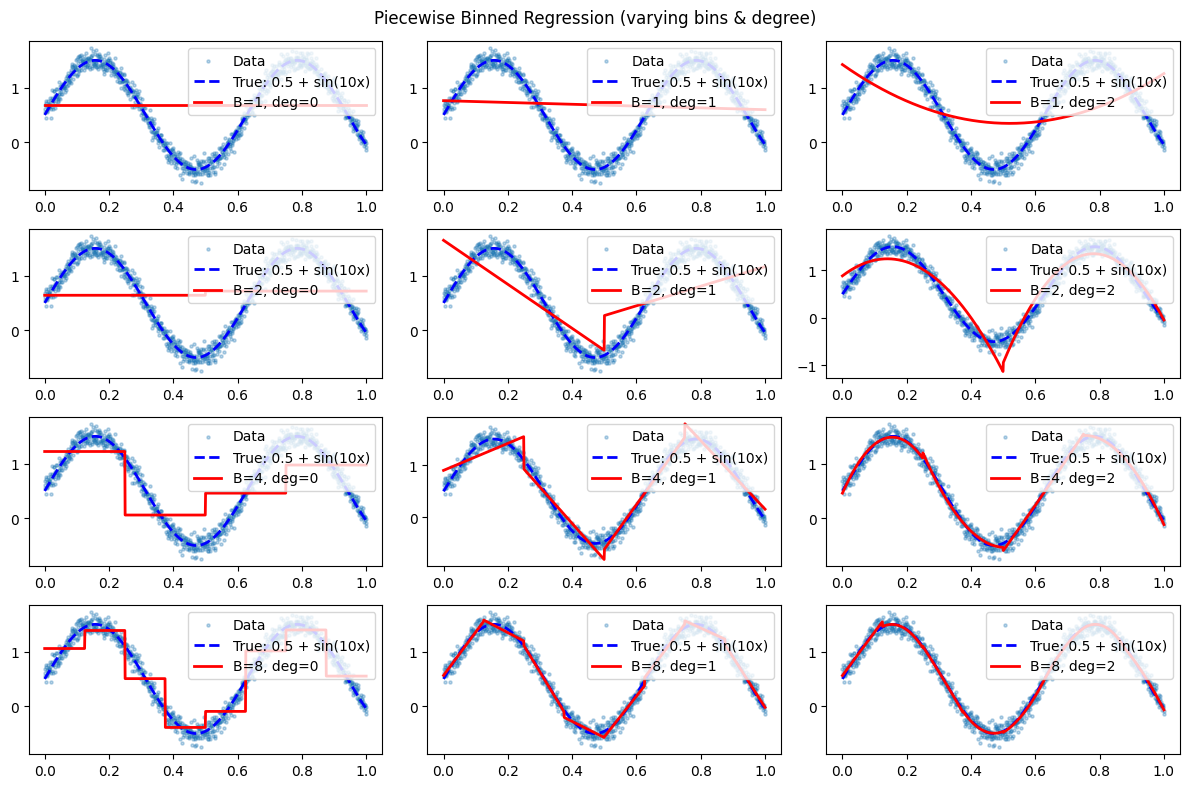

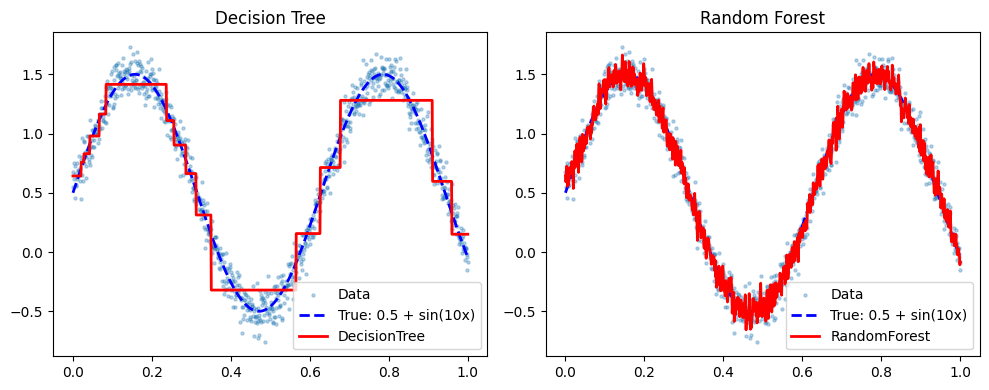

Epoch [500/2000], Loss: 0.26443
Epoch [1000/2000], Loss: 0.26443
Epoch [1500/2000], Loss: 0.26443
Epoch [2000/2000], Loss: 0.26443
Epoch [2500/2000], Loss: 0.26674
Epoch [3000/2000], Loss: 0.26443
Epoch [3500/2000], Loss: 0.26443
Epoch [4000/2000], Loss: 0.26443
Epoch [4500/2000], Loss: 0.04184
Epoch [5000/2000], Loss: 0.01270
Epoch [5500/2000], Loss: 0.01419
Epoch [6000/2000], Loss: 0.01326
Epoch [6500/2000], Loss: 0.01239
Epoch [7000/2000], Loss: 0.01238
Epoch [7500/2000], Loss: 0.01345
Epoch [8000/2000], Loss: 0.01254
Epoch [8500/2000], Loss: 0.01274
Epoch [9000/2000], Loss: 0.01298
Epoch [9500/2000], Loss: 0.01252
Epoch [10000/2000], Loss: 0.01235


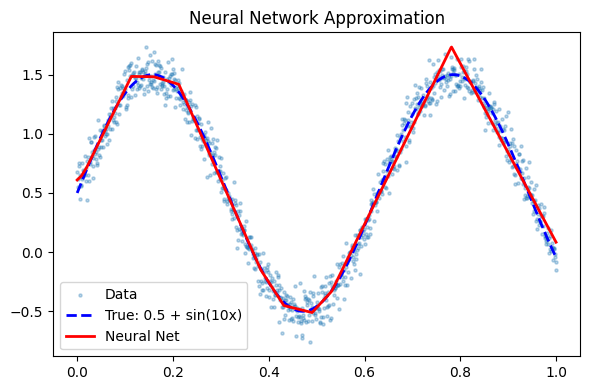

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(0)
torch.manual_seed(0)

# --- 1. Generate Data ---
N = 1000
X = np.linspace(0, 1, N)  # [0,1]
Y_true = 0.5 + np.sin(10*X)
noise = np.random.normal(0, 0.1, N)
Y = Y_true + noise

# For plotting convenience
def plot_truth(ax):
    ax.plot(X, Y_true, 'b--', linewidth=2, label='True: 0.5 + sin(10x)')

# --- 2. Piecewise Binned Regression ---
def piecewise_binning(X, Y, bins=2, poly_deg=0):
    """
    Splits [0,1] into 'bins' intervals.
    On each interval, fits polynomial of degree=poly_deg.
    Returns predictions over the entire domain X.
    """
    # Identify bin edges
    edges = np.linspace(0, 1, bins+1)
    pred = np.zeros_like(X)
    for i in range(bins):
        # Indices for data in [edges[i], edges[i+1])
        idx = (X >= edges[i]) & (X <= edges[i+1])
        # Fit polynomial on that bin
        p = np.polyfit(X[idx], Y[idx], poly_deg)
        # Evaluate on that bin
        pred[idx] = np.polyval(p, X[idx])
    return pred

# Example usage of piecewise binning
bins_list = [1, 2, 4, 8]
poly_deg_list = [0, 1, 2]

fig, axes = plt.subplots(len(bins_list), len(poly_deg_list), figsize=(12, 8))
for i, b in enumerate(bins_list):
    for j, d in enumerate(poly_deg_list):
        ax = axes[i][j]
        preds = piecewise_binning(X, Y, bins=b, poly_deg=d)
        ax.scatter(X, Y, s=5, alpha=0.3, label='Data')
        plot_truth(ax)
        ax.plot(X, preds, 'r-', linewidth=2, label=f'B={b}, deg={d}')
        ax.legend(loc='upper right')
plt.suptitle("Piecewise Binned Regression (varying bins & degree)")
plt.tight_layout()
plt.show()

# --- 3. Decision Tree & Random Forest ---
tree = DecisionTreeRegressor(max_depth=4, random_state=0)
tree.fit(X.reshape(-1,1), Y)
tree_preds = tree.predict(X.reshape(-1,1))

forest = RandomForestRegressor(n_estimators=100, random_state=0)
forest.fit(X.reshape(-1,1), Y)
forest_preds = forest.predict(X.reshape(-1,1))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X, Y, s=5, alpha=0.3, label='Data')
plot_truth(plt.gca())
plt.plot(X, tree_preds, 'r-', linewidth=2, label='DecisionTree')
plt.legend()
plt.title("Decision Tree")

plt.subplot(1,2,2)
plt.scatter(X, Y, s=5, alpha=0.3, label='Data')
plot_truth(plt.gca())
plt.plot(X, forest_preds, 'r-', linewidth=2, label='RandomForest')
plt.legend()
plt.title("Random Forest")
plt.tight_layout()
plt.show()

# --- 4. Deep Net with PyTorch ---
# Convert to torch tensors
X_torch = torch.tensor(X, dtype=torch.float32).view(-1,1)
Y_torch = torch.tensor(Y, dtype=torch.float32).view(-1,1)

# Define a small network
class SimpleNet(nn.Module):
    def __init__(self, hidden=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = SimpleNet(hidden=20)
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
for epoch in range(10_000):
    optimizer.zero_grad()
    outputs = net(X_torch)
    loss = criterion(outputs, Y_torch)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/2000], Loss: {loss.item():.5f}")

# Final predictions
with torch.no_grad():
    nn_preds = net(X_torch).numpy().flatten()

plt.figure(figsize=(6,4))
plt.scatter(X, Y, s=5, alpha=0.3, label='Data')
plot_truth(plt.gca())
plt.plot(X, nn_preds, 'r-', linewidth=2, label='Neural Net')
plt.legend()
plt.title("Neural Network Approximation")
plt.tight_layout()
plt.show()


### PyTorch for Linear Regression

1. **Model Setup**  
   - Create a single linear layer `nn.Linear(d_in, 1)` in PyTorch with:  
     - Weights $W \in \mathbb{R}^{1 \times d_\text{in}}$  
     - Bias $b \in \mathbb{R}$  
   - The layer maps $X$ (an $n \times d_\text{in}$ tensor) to predictions $y_\text{pred} = X \cdot W^\top + b$.

2. **Loss Function**  
   - Define the sum of squared errors using `nn.MSELoss(reduction='sum')`:  
     $\text{Loss}(W, b) = \sum_{i=1}^{n} \bigl(y_i - (b + \mathbf{x}_i \cdot \mathbf{w})\bigr)^2$.

3. **Backpropagation**  
   - PyTorch automatically computes gradients $\partial \text{Loss} / \partial W$ and $\partial \text{Loss} / \partial b$ via autograd.
   - Each training iteration:
     - Forward pass: compute $y_\text{pred}$ and loss.  
     - Backward pass: call `loss.backward()` to populate `.grad` fields for parameters.  
     - Update parameters: use an optimizer (e.g., Adam) to step in the negative gradient direction.

4. **Convergence to OLS**  
   - In a perfectly linear setting, with enough iterations and an appropriate learning rate, the neural network solution converges close to the Ordinary Least Squares (OLS) solution, since both minimize:  
     $\min_{W, b} \sum (y_i - b - \mathbf{x}_i \cdot \mathbf{w})^2$.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import t

##############################################
# 1) Generate linear data: y = 2 + 0.2*X1 -1.3*X2 -0.5*X3 + noise
##############################################
np.random.seed(0)
torch.manual_seed(0)

n = 1000
d_in = 3

X_raw = np.random.randn(n, d_in)
noise = np.random.randn(n, 1)
y_raw = 2.0 + 0.2*X_raw[:,[0]] - 1.3*X_raw[:,[1]] - 0.5*X_raw[:,[2]] + noise

# For OLS, build a design matrix with a column of 1s for intercept
# X_ols has shape [n, d_in+1] => [1, x1, x2, x3]
ones = np.ones((n, 1))
X_ols = np.hstack([ones, X_raw])  # shape (n,4)
y_ols = y_raw                     # shape (n,1)

##############################################
# 2) Train PyTorch model (single linear layer)
##############################################
X_torch = torch.tensor(X_raw, dtype=torch.float32)
y_torch = torch.tensor(y_raw, dtype=torch.float32)

model = nn.Sequential(nn.Linear(d_in, 1))
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

num_epochs = 1000
for epoch in range(num_epochs):
    y_pred = model(X_torch)
    loss = criterion(y_pred, y_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract PyTorch parameters: [bias, w1, w2, w3]
with torch.no_grad():
    bias_pt = model[0].bias.item()
    weight_pt = model[0].weight.view(-1).numpy()  # shape (3,)
param_pt = np.concatenate(([bias_pt], weight_pt))

##############################################
# 3) OLS estimates using closed-form solution
##############################################
# Beta_hat = (X^T X)^(-1) X^T y
# We'll do all in numpy
XTX = X_ols.T @ X_ols        # shape (4,4)
XTX_inv = np.linalg.inv(XTX) # might need damping if singular

XTy = X_ols.T @ y_ols        # shape (4,1)
beta_ols = XTX_inv @ XTy     # shape (4,1)

beta_ols = beta_ols.flatten()  # => array of length 4: [intercept, w1, w2, w3]

# Residuals & sigma^2
y_hat_ols = X_ols @ beta_ols.reshape(-1,1)
residuals = y_ols - y_hat_ols
n_params = X_ols.shape[1]  # 4
df = n - n_params
rss = np.sum(residuals**2)
sigma2_hat = rss / df

# Covariance & standard errors
cov_beta = sigma2_hat * XTX_inv  # shape (4,4)
std_errs = np.sqrt(np.diag(cov_beta))  # length 4

# t-stats, p-values, 95% conf intervals
t_vals = beta_ols / std_errs
p_vals = 2*(1 - t.cdf(np.abs(t_vals), df=df))
alpha = 0.05
crit = t.ppf(1 - alpha/2, df=df)
ci_lower = beta_ols - crit*std_errs
ci_upper = beta_ols + crit*std_errs

##############################################
# 4) Prepare a results table
##############################################
labels = ["(Intercept)","x1","x2","x3"]
rows = []
for i, lab in enumerate(labels):
    row = {
        "Parameter":    lab,
        "PyTorch_Est":  f"{param_pt[i]:.4f}",
        "OLS_Est":      f"{beta_ols[i]:.4f}",
        "Std_Err":      f"{std_errs[i]:.4f}",
        "t_Value":      f"{t_vals[i]:.4f}",
        "p_Value":      f"{p_vals[i]:.4g}",
        "CI_Lower":     f"{ci_lower[i]:.4f}",
        "CI_Upper":     f"{ci_upper[i]:.4f}"
    }
    rows.append(row)

df_res = pd.DataFrame(rows)
display(df_res)


,Parameter,PyTorch_Est,OLS_Est,Std_Err,t_Value,p_Value,CI_Lower,CI_Upper
0,(Intercept),1.9813,1.9814,0.0322,61.4863,0,1.9181,2.0446
1,x1,0.2329,0.2329,0.0340,6.8570,1.232e-11,0.1662,0.2995
2,x2,-1.2932,-1.2932,0.0324,-39.9018,0,-1.3568,-1.2296
3,x3,-0.5019,-0.5019,0.0332,-15.1236,0,-0.5671,-0.4368


## Normal vs Gumbel

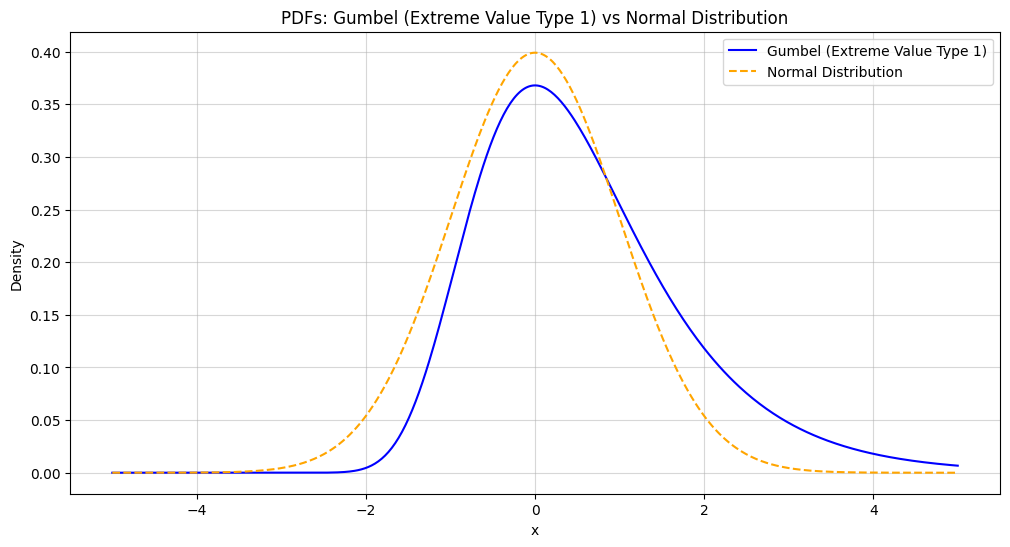

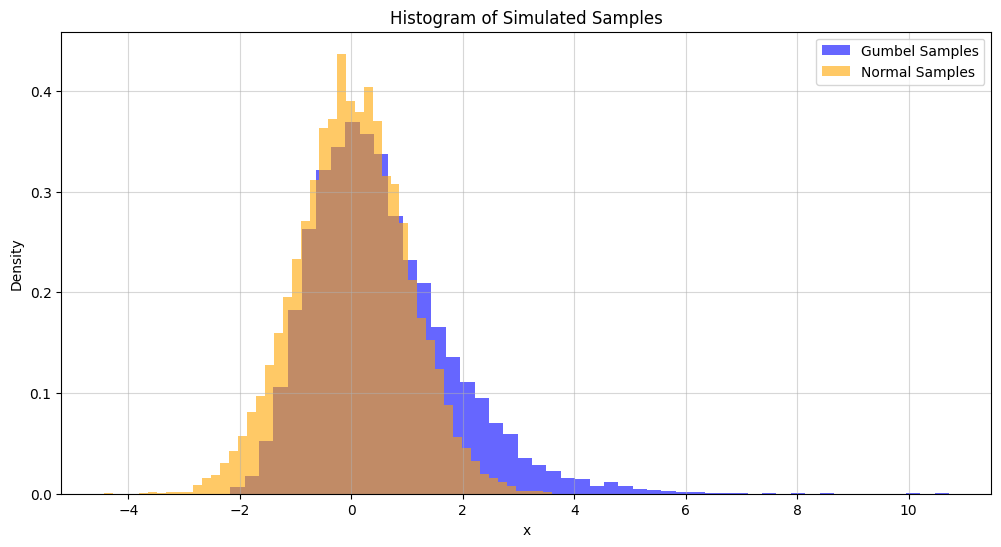

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gumbel_r

# Parameters
n_samples = 10000
x_range = np.linspace(-5, 5, 500)

# 1. Extreme Value Type 1 Distribution (Gumbel)
gumbel_mean, gumbel_scale = 0, 1
gumbel_samples = gumbel_r.rvs(loc=gumbel_mean, scale=gumbel_scale, size=n_samples)
gumbel_pdf = gumbel_r.pdf(x_range, loc=gumbel_mean, scale=gumbel_scale)

# 2. Normal Distribution
normal_mean, normal_std = 0, 1
normal_samples = np.random.normal(loc=normal_mean, scale=normal_std, size=n_samples)
normal_pdf = norm.pdf(x_range, loc=normal_mean, scale=normal_std)

# Plot PDFs
plt.figure(figsize=(12, 6))

# PDF of Gumbel Distribution
plt.plot(x_range, gumbel_pdf, label="Gumbel (Extreme Value Type 1)", linestyle='-', color='blue')

# PDF of Normal Distribution
plt.plot(x_range, normal_pdf, label="Normal Distribution", linestyle='--', color='orange')

# Add details
plt.title("PDFs: Gumbel (Extreme Value Type 1) vs Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Plot Samples (Histogram)
plt.figure(figsize=(12, 6))

# Histogram of Gumbel Samples
plt.hist(gumbel_samples, bins=50, density=True, alpha=0.6, color='blue', label="Gumbel Samples")

# Histogram of Normal Samples
plt.hist(normal_samples, bins=50, density=True, alpha=0.6, color='orange', label="Normal Samples")

# Add details
plt.title("Histogram of Simulated Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


## Causal Forests

ATE Results:
            Metric     Value
0              ATE  2.757602
1  ATE Lower Bound  2.304825
2  ATE Upper Bound  3.210378
3         True ATE  2.773240

CATE Results for X_test:
       X_test  CATE Estimate  CATE Lower Bound  CATE Upper Bound  True CATE
0  [0.5, 0.5]       3.479878          3.173793          3.785963   3.500000
1  [0.2, 0.8]       3.759978          3.398682          4.121275   3.575571
2  [0.9, 0.1]       0.868199          0.315591          1.420807   0.918034


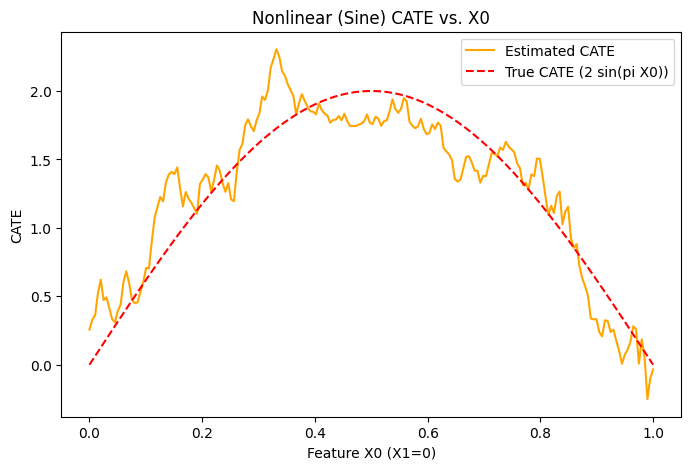

In [15]:
import numpy as np
import pandas as pd
from econml.dml import CausalForestDML
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# =========================
# 1) Generate synthetic data
# =========================
np.random.seed(123)

n = 100_000
X = np.random.uniform(0, 1, size=(n, 2))     # Features in [0,1]
W = np.random.normal(size=(n, 3))           # Covariates
T = np.random.binomial(1, 0.5, size=(n,))   # Binary treatment

# True CATE = 2 sin(pi * X0) + 3 * X1
# We'll define Y = Y(0) + T * tau(X).
# Let Y(0) = X0 + X1 + W0 + eps
def true_cate(x):
    return 2 * np.sin(np.pi * x[:, 0]) + 3 * x[:, 1]

# Construct Y:
#    Y(0) = X0 + X1 + W0 + noise
#    Y(1) = Y(0) + 2 sin(pi X0) + 3 X1
noise = np.random.normal(size=n)
Y0 = X[:, 0] + X[:, 1] + W[:, 0] + noise
Y = Y0 + T * true_cate(X)

# True ATE = E[tau(X)] with X0, X1 ~ Uniform(0,1)
# E[sin(pi*X0)] = 2/pi, E[X1] = 0.5 => ATE = 2*(2/pi)+3*(0.5)= 4/pi + 1.5
true_ate_value = 4/np.pi + 1.5


# =========================
# 2) Causal Forest Estimator
# =========================
est = CausalForestDML(
    model_y=LGBMRegressor(verbose=-1),
    model_t=LGBMRegressor(verbose=-1),
    discrete_treatment=True,
    random_state=123,
    n_estimators=100,
    criterion='mse',
    max_depth=None
)

# Fit the model
est.fit(Y, T, X=X, W=W)

# =========================
# 3) ATE estimates
# =========================
ate = est.ate(X=X)
ate_interval = est.ate_interval(X=X)

# Put results in a DataFrame (including True ATE)
ate_table = pd.DataFrame({
    "Metric": ["ATE", "ATE Lower Bound", "ATE Upper Bound", "True ATE"],
    "Value": [ate, ate_interval[0], ate_interval[1], true_ate_value]
})

# =========================
# 4) CATE estimates for some chosen points
# =========================
X_test = np.array([
    [0.5, 0.5],    # near the midpoint
    [0.2, 0.8],    # different region
    [0.9, 0.1]     # different region
])
cate = est.effect(X_test)                       # estimated CATE
cate_inference = est.effect_inference(X_test)
cate_interval = cate_inference.conf_int()

# True CATE for those points
true_cate_test = true_cate(X_test)

cate_table = pd.DataFrame({
    "X_test": list(X_test),
    "CATE Estimate": cate,
    "CATE Lower Bound": cate_interval[0],
    "CATE Upper Bound": cate_interval[1],
    "True CATE": true_cate_test
})

# =========================
# 5) Print results
# =========================
print("ATE Results:")
print(ate_table)

print("\nCATE Results for X_test:")
print(cate_table)

# =========================
# 6) Visualize CATE vs. X[:,0], fix X[:,1] = 0
# =========================
# For the plot, set X1 = 0, so CATE(X) = 2 sin(pi X0) + 3*0 = 2 sin(pi X0).
n_plot = 200
X_plot = np.linspace(0, 1, n_plot).reshape(-1, 1)
X_plot_full = np.hstack((X_plot, np.zeros_like(X_plot)))  # fix X1=0

cate_plot = est.effect(X_plot_full)       # Estimated CATE from the model
true_cate_plot = 2 * np.sin(np.pi * X_plot[:, 0])  # 2 sin(pi X0)

plt.figure(figsize=(8, 5))
plt.plot(X_plot[:, 0], cate_plot, label="Estimated CATE", color='orange')
plt.plot(X_plot[:, 0], true_cate_plot, 'r--', label="True CATE (2 sin(pi X0))")
plt.xlabel("Feature X0 (X1=0)")
plt.ylabel("CATE")
plt.title("Nonlinear (Sine) CATE vs. X0")
plt.legend()
plt.show()
